In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/data/results.csv')
df_abstract = pd.read_csv('/content/drive/MyDrive/data/results_abstract.csv', delimiter='|')

In [8]:
df.head()

,Document/Patent number,Title,Inventor name,Publication date
0,US-20240291672-A1,ELECTRONIC SYSTEM FOR GENERATING AND TRACKING ...,Kurian; Manu Jacob,2024-08-29
1,US-20240289486-A1,SYSTEM AND METHOD FOR SECURING INFORMATION IN ...,Madiya; Tirupathirao et al.,2024-08-29
2,US-20240291681-A1,System And Method For Managing Exception Reque...,Khare; Prashant et al.,2024-08-29
3,US-20240289192-A1,SYSTEM AND METHOD FOR PROCESSING OF EVENT DATA...,Dintenfass; Katherine Kei-Zen et al.,2024-08-29
4,US-20240291652-A1,SYSTEM FOR MONITORING ACCESS TO A VIRTUAL ENVI...,Mamadapur; Krishna Rangarao et al.,2024-08-29


In [9]:
df_abstract.head()

,Document/Patent number,abstract,filed_date,name
0,US-20240291672-A1,"Systems, computer program products, and method...","April 29, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)"
1,US-20240289486-A1,Embodiments of the invention are directed to a...,"May 02, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)"
2,US-20240291681-A1,A system for resolving exceptions in requests ...,"May 07, 2024","Bank of America Corporation (Charlotte, NC)"
3,US-20240289192-A1,"Systems, computer program products, and method...","April 29, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)"
4,US-20240291652-A1,"Systems, computer program products, and method...","February 23, 2023","BANK OF AMERICA CORPORATION (Charlotte, NC)"


In [10]:
def clean_string(s):
  return s.translate(str.maketrans('', '', string.punctuation)).lower()

df_main = df_abstract.merge(df, on='Document/Patent number', how='left')
df_main['abstract'] = df_main['abstract'].apply(clean_string)
df_main['Title'] = df_main['Title'].apply(clean_string)

df_main['Publication date'] = pd.to_datetime(df_main['Publication date'], format='%Y-%m-%d')
print(df_main.info())
df_main.describe()
df_main.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9452 entries, 0 to 9451
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Document/Patent number  9452 non-null   object        
 1   abstract                9452 non-null   object        
 2   filed_date              9452 non-null   object        
 3   name                    9452 non-null   object        
 4   Title                   9452 non-null   object        
 5   Inventor name           9452 non-null   object        
 6   Publication date        9452 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 517.0+ KB
None


,Document/Patent number,abstract,filed_date,name,Title,Inventor name,Publication date
0,US-20240291672-A1,systems computer program products and methods ...,"April 29, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)",electronic system for generating and tracking ...,Kurian; Manu Jacob,2024-08-29
1,US-20240289486-A1,embodiments of the invention are directed to a...,"May 02, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)",system and method for securing information in ...,Madiya; Tirupathirao et al.,2024-08-29
2,US-20240291681-A1,a system for resolving exceptions in requests ...,"May 07, 2024","Bank of America Corporation (Charlotte, NC)",system and method for managing exception reque...,Khare; Prashant et al.,2024-08-29
3,US-20240289192-A1,systems computer program products and methods ...,"April 29, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)",system and method for processing of event data...,Dintenfass; Katherine Kei-Zen et al.,2024-08-29
4,US-20240291652-A1,systems computer program products and methods ...,"February 23, 2023","BANK OF AMERICA CORPORATION (Charlotte, NC)",system for monitoring access to a virtual envi...,Mamadapur; Krishna Rangarao et al.,2024-08-29
5,US-20240289097-A1,an architecture for writing software programs ...,"February 23, 2023","Bank of America Corporation (Charlotte, NC)",hierarchical software processing using federat...,Goswami; Debraj et al.,2024-08-29
6,US-20240289581-A1,a method for increasing the security of quick ...,"February 06, 2024","Bank of America Corporation (Charlotte, NC)",dynamic hidden nonfungible token nft placehold...,Singh; Shailendra et al.,2024-08-29
7,US-20240290182-A1,an atm includes a long range wan module that p...,"February 23, 2023","Bank of America Corporation (Charlotte, NC)",automated teller machine atm transaction resli...,Sethia; Maneesh Kumar et al.,2024-08-29
8,US-12072965-B2,the present invention is generally related to ...,"September 26, 2023","BANK OF AMERICA CORPORATION (Charlotte, NC)",systems and methods for geolocation security u...,Sims; Scott Anderson et al.,2024-08-27
9,US-12074641-B2,a system for implementing a secured data trans...,"February 15, 2022","Bank of America Corporation (Charlotte, NC)",system and method for secured data transmissio...,Arumugam Maharaja; Raja et al.,2024-08-27


## Classification using keywords

In [11]:
# Extract abstract and title into a list of words list

def get_word_distribution(texts):
  word_distribution = {}
  for text in texts:
    for word in text:
      if word in word_distribution:
        word_distribution[word] += 1
      else:
        word_distribution[word] = 1
  return word_distribution

def sort_word_distribution(word_distribution):
  return {k: v for k, v in sorted(word_distribution.items(), key=lambda item: item[1], reverse=True)}

df_main['combined text'] = df_main['abstract'] + ' ' + df_main['Title']
texts = df_main['combined text'].tolist()
texts = [text.split(' ') for text in texts]

word_distribution = get_word_distribution(texts)
word_distribution = sort_word_distribution(word_distribution)

In [12]:
vocabulary_dict = {
    'ai': ['ai', 'learning', 'chat', 'bot', 'bots', 'chatbot', 'chatbots', 'artificial', 'intelligence', 'deep', 'neural', 'artificialintelligence', 'generative', 'nlp', 'lstm', 'cnn', 'autoencoder', 'predictive'],
    'blockchain': ['nft', 'block', 'chain', 'blockchain', 'certificate', 'cryptocurrency', 'metaverse', 'nonfungible', 'nfts', 'digitalbitcoin', 'ledgers'],
    'cybersecurity': ['authentication', 'verification', 'signature', 'token', 'vulnerability', 'attack', 'attacks', 'securely', 'secure', 'encrypt', 'phishing', 'security', 'cybersecurity', 'pii', 'malicious', 'dmz'],
    'IT architecture': ['quantum', 'infrastructure', 'infrastructures', 'cloud', 'server', 'virtual',  'backup', 'hardware'],
    'software':  ['lpwan', 'module'],
    'atm machines': ['atm']
}

vocab_importance = ['blockchain', 'cybersecurity', 'software', 'atm machines', 'IT architecture', 'ai']

In [13]:
for word_list, topic in zip(vocabulary_dict.values(), vocabulary_dict):
  print(topic)
  for word in word_list:
    print(f'{word}: {word_distribution[word]}')
  print('\n')

ai
ai: 302
learning: 1697
chat: 101
bot: 164
bots: 86
chatbot: 89
chatbots: 23
artificial: 469
intelligence: 487
deep: 77
neural: 398
artificialintelligence: 8
generative: 22
nlp: 35
lstm: 5
cnn: 23
autoencoder: 5
predictive: 206


blockchain
nft: 394
block: 698
chain: 449
blockchain: 554
certificate: 274
cryptocurrency: 124
metaverse: 120
nonfungible: 182
nfts: 62
digitalbitcoin: 3
ledgers: 45


cybersecurity
authentication: 3924
verification: 450
signature: 240
token: 1403
vulnerability: 245
attack: 151
attacks: 62
securely: 101
secure: 1344
encrypt: 96
phishing: 168
security: 2432
cybersecurity: 79
pii: 85
malicious: 340
dmz: 11


IT architecture
quantum: 443
infrastructure: 293
infrastructures: 10
cloud: 441
server: 2600
virtual: 1411
backup: 81
hardware: 343


software
lpwan: 5
module: 997


atm machines
atm: 987




In [14]:
topic_class = []
topic_class_index = []
for abstract in df_main['combined text']:
  found = False
  for topic in vocab_importance:
    for word in vocabulary_dict[topic]:
      if word in abstract:
        topic_class.append(topic)
        topic_class_index.append(vocab_importance.index(topic))
        found = True
        break
    if found:
      break
  else:
    topic_class.append('other')
    topic_class_index.append(-1)
df_main['topic'] = topic_class
df_main['topic index'] = topic_class_index

In [15]:
df_main.head()

,Document/Patent number,abstract,filed_date,name,Title,Inventor name,Publication date,combined text,topic,topic index
0,US-20240291672-A1,systems computer program products and methods ...,"April 29, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)",electronic system for generating and tracking ...,Kurian; Manu Jacob,2024-08-29,systems computer program products and methods ...,blockchain,0
1,US-20240289486-A1,embodiments of the invention are directed to a...,"May 02, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)",system and method for securing information in ...,Madiya; Tirupathirao et al.,2024-08-29,embodiments of the invention are directed to a...,blockchain,0
2,US-20240291681-A1,a system for resolving exceptions in requests ...,"May 07, 2024","Bank of America Corporation (Charlotte, NC)",system and method for managing exception reque...,Khare; Prashant et al.,2024-08-29,a system for resolving exceptions in requests ...,blockchain,0
3,US-20240289192-A1,systems computer program products and methods ...,"April 29, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)",system and method for processing of event data...,Dintenfass; Katherine Kei-Zen et al.,2024-08-29,systems computer program products and methods ...,ai,5
4,US-20240291652-A1,systems computer program products and methods ...,"February 23, 2023","BANK OF AMERICA CORPORATION (Charlotte, NC)",system for monitoring access to a virtual envi...,Mamadapur; Krishna Rangarao et al.,2024-08-29,systems computer program products and methods ...,IT architecture,4


In [16]:
df_main.groupby("topic").count()

,Document/Patent number,abstract,filed_date,name,Title,Inventor name,Publication date,combined text,topic index
topic,,,,,,,,,
IT architecture,925,925,925,925,925,925,925,925,925
ai,1873,1873,1873,1873,1873,1873,1873,1873,1873
atm machines,153,153,153,153,153,153,153,153,153
blockchain,793,793,793,793,793,793,793,793,793
cybersecurity,2721,2721,2721,2721,2721,2721,2721,2721,2721
other,2646,2646,2646,2646,2646,2646,2646,2646,2646
software,341,341,341,341,341,341,341,341,341


## Using BERT and KNN to classify others

In [17]:
from transformers import BertTokenizer, BertModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
# List of sentences
X_train = []
X_unknown = []
for i, sentence in tqdm(enumerate(df_main[df_main['topic index'] != -1]['combined text'].tolist())):
    # Tokenize and encode the sentences
    inputs = tokenizer([sentence], return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs.to(device)

    # Get the embeddings from BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # The last hidden state of the model (batch_size, sequence_length, hidden_size)
    last_hidden_state = outputs.last_hidden_state

    # Extract the [CLS] token representation for each sentence
    sentence_embeddings = last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
    X_train.append(sentence_embeddings.to('cpu').numpy()[0])

for i, sentence in tqdm(enumerate(df_main[df_main['topic index'] == -1]['combined text'].tolist())):
    # Tokenize and encode the sentences
    inputs = tokenizer([sentence], return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs.to(device)

    # Get the embeddings from BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # The last hidden state of the model (batch_size, sequence_length, hidden_size)
    last_hidden_state = outputs.last_hidden_state

    # Extract the [CLS] token representation for each sentence
    sentence_embeddings = last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
    X_unknown.append(sentence_embeddings.to('cpu').numpy()[0])

6806it [01:15, 89.71it/s]
2646it [00:28, 92.39it/s]


In [19]:
y = df_main[df_main['topic index'] != -1]['topic index'].to_numpy()

In [20]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y)

KNeighborsClassifier()

In [21]:
neigh.predict(X_unknown)

array([1, 1, 4, ..., 1, 3, 0])

In [22]:
df_others = df_main[df_main['topic index'] == -1]
df_others['predicted index'] = list(neigh.predict(X_unknown))

<ipython-input-22-e9d00d45b9a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_others['predicted index'] = list(neigh.predict(X_unknown))


In [23]:
df_others.head(20)

,Document/Patent number,abstract,filed_date,name,Title,Inventor name,Publication date,combined text,topic,topic index,predicted index
5,US-20240289097-A1,an architecture for writing software programs ...,"February 23, 2023","Bank of America Corporation (Charlotte, NC)",hierarchical software processing using federat...,Goswami; Debraj et al.,2024-08-29,an architecture for writing software programs ...,other,-1,1
18,US-20240281552-A1,a system for validating a response based on co...,"April 29, 2024","Bank of America Corporation (Charlotte, NC)",system and method for validating a response ba...,Trivedi; Abhishek et al.,2024-08-22,a system for validating a response based on co...,other,-1,1
27,US-20240282125-A1,a system for increasing a resolution of a thre...,"February 21, 2023","Bank of America Corporation (Charlotte, NC)",system and method for increasing a resolution ...,Padmanaban; Ravindran et al.,2024-08-22,a system for increasing a resolution of a thre...,other,-1,4
30,US-12067123-B2,a network connection device may include at lea...,"August 16, 2021","Bank of America Corporation (Charlotte, NC)",relayswitch with sandbox communication connect...,Haletky; Edward L.,2024-08-20,a network connection device may include at lea...,other,-1,1
34,US-12067348-B1,smart glasses may be used for intelligent ui w...,"August 04, 2023","Bank of America Corporation (Charlotte, NC)",intelligent webpage ui optimization leveraging...,Verma; Sandeep et al.,2024-08-20,smart glasses may be used for intelligent ui w...,other,-1,3
49,US-12061621-B2,methods for hybrid job processing may include ...,"July 28, 2021","Bank of America Corporation (Charlotte, NC)",bulk data extract hybrid job processing,Ebenezer; Daniel et al.,2024-08-13,methods for hybrid job processing may include ...,other,-1,4
58,US-20240267246-A1,a comprehensive system for capturing multicast...,"April 16, 2024","BANK OF AMERICA CORPORATION (Charlotte, NC)",systems for capturing messaging volume and uti...,Patel; Milan Bansilal,2024-08-08,a comprehensive system for capturing multicast...,other,-1,1
59,US-20240265143-A1,a system accesses a task log comprising text t...,"March 28, 2024","Bank of America Corporation (Charlotte, NC)",system and method for detecting and obfuscatin...,Dande; Pratap et al.,2024-08-08,a system accesses a task log comprising text t...,other,-1,1
67,US-20240267796-A1,aspects of the disclosure relate to a mobility...,"February 06, 2023","Bank of America Corporation (Charlotte, NC)",mobility protocol for narrowband internet of t...,Selvaraj; Srinivasan et al.,2024-08-08,aspects of the disclosure relate to a mobility...,other,-1,1
86,US-20240256338-A1,embodiments of the present invention provide a...,"January 27, 2023","BANK OF AMERICA CORPORATION (Charlotte, NC)",system and method for generating consolidated ...,Perraut; Trina et al.,2024-08-01,embodiments of the present invention provide a...,other,-1,5


In [24]:
df_others['abstract'][112]

'systems computer program products and methods are described herein for determining data transmission destinations across an electronic network the method includes receiving a resource data packet to be transmitted to one of a plurality of data centers across a network the resource data packet is associated with a user identifier that corresponds to one of one or more users the method also includes determining a target data center for the resource data packet based on the user identifier associated with the resource data packet one or more character of the user identifier associated with the resource data packet designates the target data center for the user associated with the user identifier of the resource data packet the method further includes causing a transmission of the resource data packet to the target data center based on the user identifier associated with the resource data packet'

## combine

In [25]:
df_combined = df_main.merge(df_others[['Document/Patent number', 'predicted index']], on='Document/Patent number', how='left')
df_combined['topic'] = df_combined.apply(
    lambda row: row['topic'] if row['topic'] != 'other' else vocab_importance[int(row['predicted index'])],
    axis=1
)
df_combined = df_combined.drop(columns=['predicted index', 'topic index'])

In [26]:
df_combined.groupby('topic').count()

,Document/Patent number,abstract,filed_date,name,Title,Inventor name,Publication date,combined text
topic,,,,,,,,
IT architecture,1241,1241,1241,1241,1241,1241,1241,1241
ai,2857,2857,2857,2857,2857,2857,2857,2857
atm machines,184,184,184,184,184,184,184,184
blockchain,1020,1020,1020,1020,1020,1020,1020,1020
cybersecurity,3688,3688,3688,3688,3688,3688,3688,3688
software,462,462,462,462,462,462,462,462


In [27]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9452 entries, 0 to 9451
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Document/Patent number  9452 non-null   object        
 1   abstract                9452 non-null   object        
 2   filed_date              9452 non-null   object        
 3   name                    9452 non-null   object        
 4   Title                   9452 non-null   object        
 5   Inventor name           9452 non-null   object        
 6   Publication date        9452 non-null   datetime64[ns]
 7   combined text           9452 non-null   object        
 8   topic                   9452 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 664.7+ KB


In [28]:
df_combined['year'] = df_combined['Publication date'].dt.to_period('Y')
topic_counts = df_combined.groupby(['year', 'topic']).size().reset_index(name='counts')
topic_counts['year'] = topic_counts['year'].astype(str)
topic_counts = topic_counts[topic_counts['year'] != '2024']

In [29]:
topic_counts

,year,topic,counts
0,2015,IT architecture,60
1,2015,ai,208
2,2015,atm machines,10
3,2015,blockchain,30
4,2015,cybersecurity,173
5,2015,software,43
6,2016,IT architecture,92
7,2016,ai,263
8,2016,atm machines,33
9,2016,blockchain,32


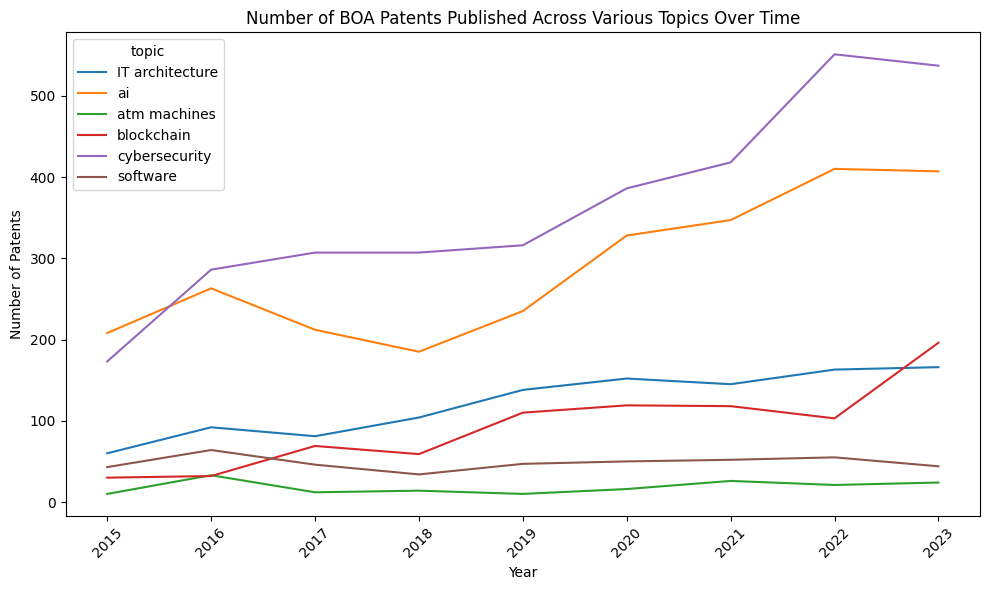

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=topic_counts, x='year', y='counts', hue='topic')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Number of BOA Patents Published Across Various Topics Over Time')
plt.tight_layout()
plt.show()